# Correlation / Portfolio Analysis

We consider a portfolio of investments, in this case, a selection of stocks. One of the fundamental principles of investing, is in diversification of assets and here we examine practical ways of comparing the risk/return profile of different investments — whether through relative return, correlation or volatility.
It is also important for presentation to be clear; where we are faced with a large quantity of data on actual price, returns and volatility and that is just on one single stock. This will be multiples of that amount of data and charts depending on the size of the portfolio being analysed. The charts also have to tell an accurate story to lead to informed decision making. For example, where the price chart tells one thing, the relative percentage returns tells another. And where the cumulative returns of an investment from one year ago tells one thing, the cumulative returns of that investment from 6 months ago tells another.
In the below, we consider the high level summary characteristics — in particular, daily returns and histogram of this over the time period provides an like-for-like way to compare different investments. Correlation of stocks relative to one-another provides insight on each of their profile.

In [ ]:
!pip install yfinance

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import numpy as np

In [3]:
import yfinance as yf

In [4]:
import matplotlib.pyplot as plt

In [5]:
tickers = ['ba', 'aapl', 'amzn', 'tsla']
df2 = yf.download(tickers, start="2021-03-31", end="2022-03-31")

[*********************100%***********************]  4 of 4 completed


In [14]:
df2_close = df2['Adj Close']

Text(0.5, 0.98, 'Portfolio Summary')

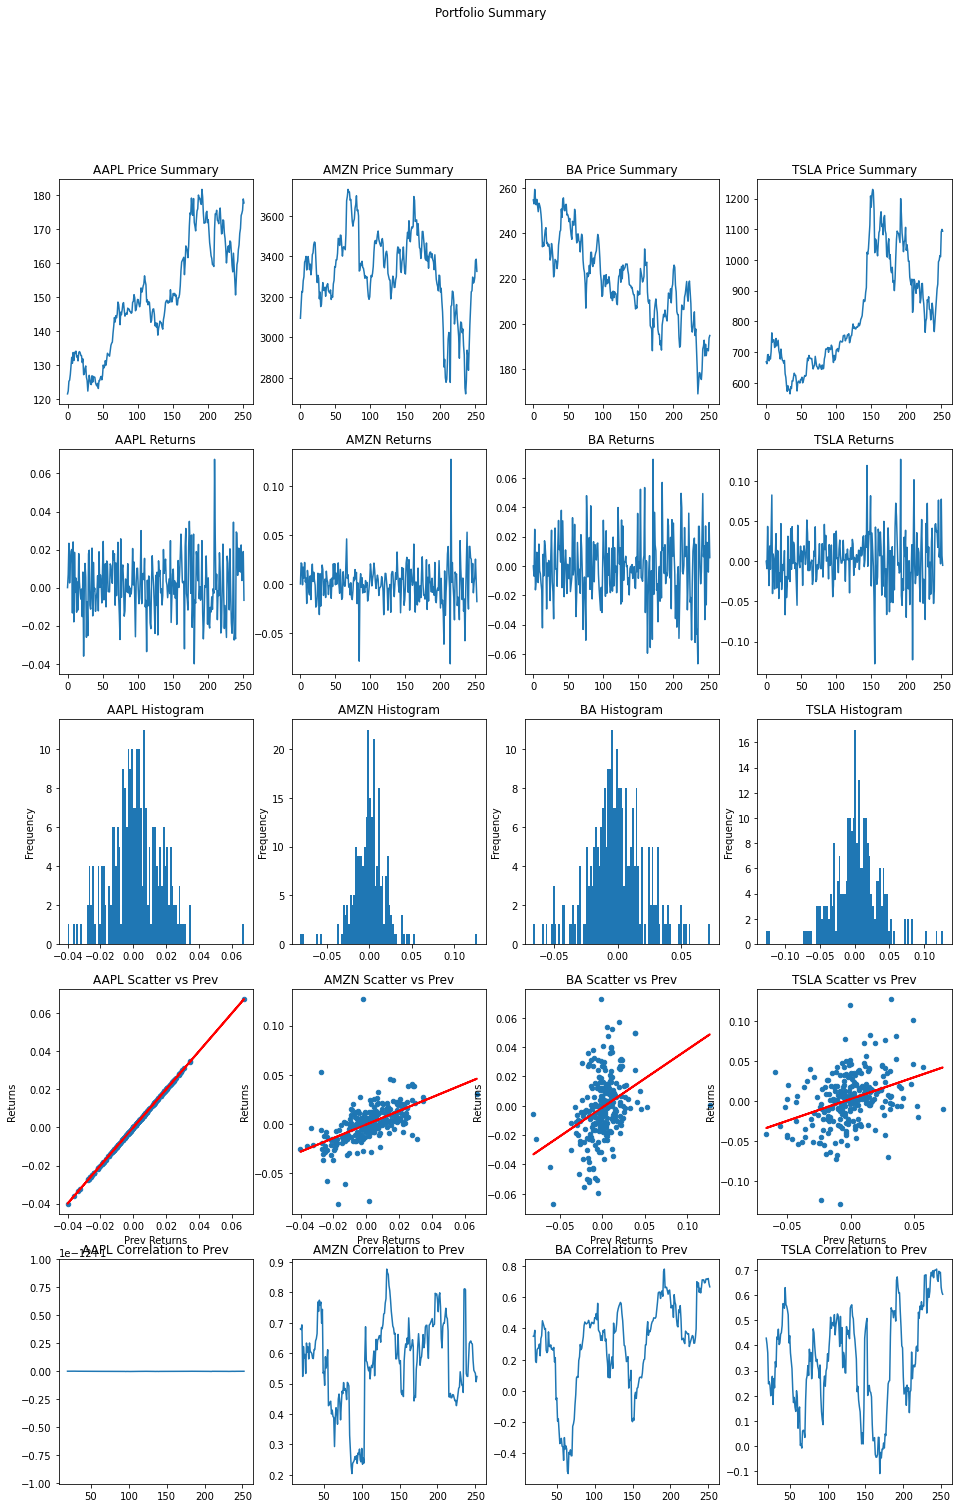

In [86]:
fig, axs = plt.subplots(5, 4)
fig.set_size_inches(16,24)
old_df = pd.DataFrame()
x = 0

for col in df2_close.columns:

    selected_series = df2_close[col].values.tolist()
    analysis = pd.DataFrame(selected_series.copy())
    analysis.columns = ["Price"]
    analysis['Returns'] = np.log(analysis["Price"] / analysis["Price"].shift(1))
    analysis = analysis.fillna(0)
    analysis["Price"].plot(title="{} Price Summary".format(col), ax=axs[0,x])
    analysis['Returns'].plot(title="{} Returns".format(col), ax=axs[1,x])
    analysis['Returns'].plot(kind='hist', bins=100, orientation='vertical', title="{} Histogram".format(col), ax=axs[2,x])
    
    if x == 0:
        analysis['Prev Returns'] = analysis['Returns']
    else: analysis['Prev Returns'] = old_df

    regression = np.polyfit(analysis['Prev Returns'], analysis['Returns'], deg=1)
    analysis[['Prev Returns', 'Returns']].plot(kind='scatter', title="{} Scatter vs Prev".format(col), x="Prev Returns", y="Returns", ax=axs[3,x])
    axs[3,x].plot(analysis['Prev Returns'], np.polyval(regression, analysis['Prev Returns']), 'r', lw=2)

    analysis['Prev Returns'].rolling(window=20).corr(analysis['Returns']).plot(title="{} Correlation to Prev".format(col), ax=axs[4,x])
    # axs[4,x].axhline(analysis['Returns'].corr().iloc[0,1], c='r')

    x += 1
    old_df = analysis['Returns']

fig.suptitle("Portfolio Summary")

In [87]:
returns = (df2['Adj Close']/ df2['Adj Close'].shift(1))
returns = returns.fillna(1)

As mentioned, the point in time at which the position is taken is also important in framing the return on investment. As demonstrated below, Tesla (in red) shows the strong percentage return versus the other stocks over the longer periods of one year (i.e. taking the position one year to nine months ago). However, in the penultimate chart on the right, over 100 trading days, Tesla has the worst relative performance of the four stocks in this portfolio.

Text(0.5, 1, 'Relative % Returns for each Investment over Time Period')

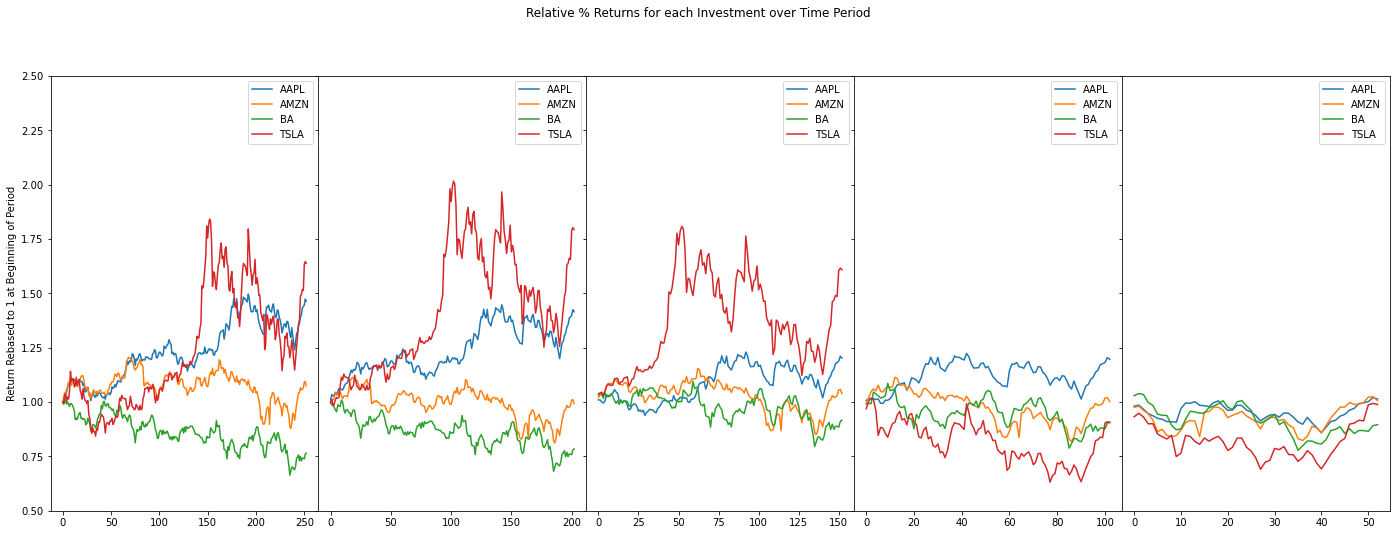

In [88]:
fig, axs = plt.subplots(1, 5, sharey=True, gridspec_kw={'wspace': 0})
fig.set_facecolor("white")
fig.set_size_inches(24, 8)
idx = 0
start = 0

for idx in range(5):

    analysis_cut = returns.iloc[start:]
    analysis_cut = analysis_cut.reset_index(drop=True)
    analysis_cut = analysis_cut.cumprod()
    analysis_cut.plot(ylim=(0.5, 2.5), ax=axs[idx])
    idx += 1
    start += 50

axs[0].set_ylabel("Return Rebased to 1 at Beginning of Period")
fig.suptitle("Relative % Returns for each Investment over Time Period", y=1)

In [ ]:
pd.plotting.scatter_matrix(returns, alpha=0.2, diagonal='hist', hist_kwds={'bins': 35}, figsize=(14,6))

## Portfolio-Level Characteristics

Moving beyond an individualised analysis of each stock, we consider the portfolio weighting in order to optimise overall portfolio return versus portfolio volatility. With the returns for each stock, we can calculate the correlation and covariance in order to simulate different weightings of the portfolio and calculate the portfolio-level return and volatility. This produces the following chart, called an Efficiency Frontier from which we can derive the weighting that achieves the lowest volatility (i.e. along the frontier to the left that minimises the x-axis) or the highest return (by maximising the y-axis).

In [89]:
import seaborn as sns

In [90]:
returns = np.log(df2['Adj Close']/ df2['Adj Close'].shift(1))
returns.dropna(inplace=True)

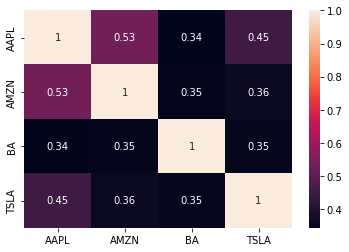

In [91]:
sns.heatmap(returns.corr(), xticklabels=returns.columns, yticklabels=returns.columns, annot=True)

In [92]:
cov_matrix = returns.cov()
corr_matrix = returns.corr()
returns_overall = returns.mean()

In [93]:
p_ret = []
p_vol = []
p_weights = []
num_assets = len(returns.columns)
num_iterations = 10000

We simulate different weightings to generate portfolio returns and volatility. We can also locate the index, and therefore the weighting, that maximises the Sharpe Ratio, which incorporates the return and volatility in a ratio, which then outputs the green star in the below.

In [94]:
for portfolio in range(num_iterations):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    ret = np.dot(weights, returns_overall)

    p_ret.append(ret)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    stan_dev = np.sqrt(var)
    volatility = stan_dev*np.sqrt(250)
    p_vol.append(volatility)

data = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(df2_close.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [95]:
portfolios = pd.DataFrame(data)

In [96]:
risk_free_rate = 0.1
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-risk_free_rate)/portfolios['Volatility']).idxmax()]

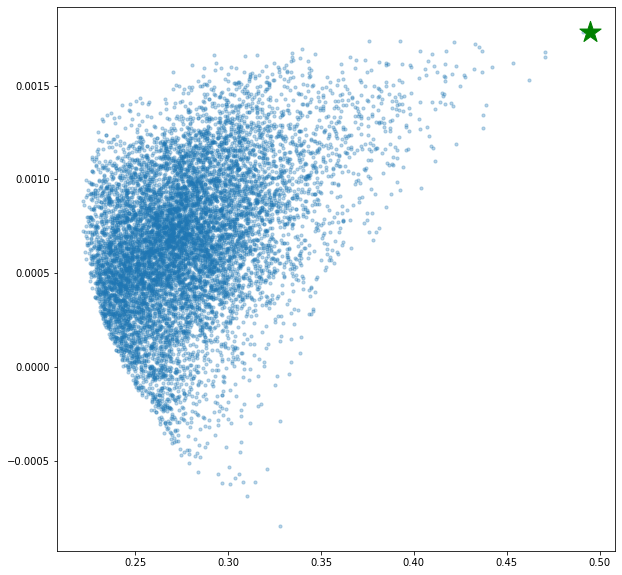

In [97]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

## Backtesting Portfolio

Here we can test any kind of trading signals in a dataframe on our investments or aggregated portfolio of investments. The idea of backtesting is to analyse the return / volatility of the defined investment strategy. There are several layers to this, the most important in this version is that the value of the positions sold is then completely reinvested at the next buy signal. I.e. the amount of holdings varies depending on the amount of "cash" versus the price at the buy signal.

In [ ]:
weights = [2, 3, 2, 3]
df2_close['Portfolio'] = df2_close.dot(weights)

In [16]:
df2_close

,AAPL,AMZN,BA,TSLA,Portfolio
Date,,,,,
2021-03-31,121.428284,3094.080078,254.720001,667.929993,12038.326782
2021-04-01,122.273262,3161.000000,252.960007,661.750000,12218.716537
2021-04-05,125.156136,3226.729980,259.359985,691.049988,12522.372147
2021-04-06,125.464302,3223.820068,255.169998,691.619995,12507.588791
2021-04-07,127.144325,3279.389893,252.580002,670.969971,12610.528244
...,...,...,...,...,...
2022-03-24,174.070007,3272.989990,189.050003,1013.919983,13586.969940
2022-03-25,174.720001,3295.469971,188.949997,1010.640015,13645.669952
2022-03-28,175.600006,3379.810059,188.160004,1091.839966,14142.470093


In [17]:
df2_close = df2_close.drop(df2_close.columns[:-1], axis=1)

In [199]:
df2_close = df2_close.drop(df2_close.columns[1:], axis=1)

**Illustrative Trading Signals**

In [ ]:
df2_close['Buy'] = 0
df2_close['Sell'] = 0
df2_close['Buy'].iloc[0] = 1
df2_close['Sell'].iloc[20] = 1
df2_close['Buy'].iloc[50] = 1
df2_close['Sell'].iloc[160] = 1
df2_close['Buy'].iloc[200] = 1

**Backtesting Dataframe Columns**

In [201]:
# Define initial holding amount and change in holding amount columns
df2_close['Holding_Amt'] = df2_close['Buy'].cumsum() - df2_close['Sell'].cumsum()
df2_close['Holding_Amt_Change'] = 0

In [ ]:
# Define returns column and portfolio return (% return when holding and 1 when not holding)
# 
df2_close['Pct_change'] = df2_close['Portfolio'] / df2_close['Portfolio'].shift(1)
df2_close = df2_close.fillna(1)

df2_close['RebasedPrice'] = df2_close['Pct_change'].cumprod()

df2_close['PortReturns'] = df2_close['Holding_Amt'] * df2_close['Pct_change']
for i in range(len(df2_close)):
    if df2_close['PortReturns'].iloc[i] == 0:
        df2_close['PortReturns'].iloc[i] = 1

In [203]:
df2_close['Value'] = 1
accumulated_return = 1

In [ ]:
for i in range(len(df2_close)):
    
    if df2_close['Buy'].iloc[i] == 1:
        df2_close['Holding_Amt_Change'].iloc[i] = df2_close['Value'].iloc[i-1]/df2_close['RebasedPrice'].iloc[i]
    else: df2_close['Holding_Amt_Change'].iloc[i] = 0
    
    if df2_close['Sell'].iloc[i] == 1:
        df2_close['Holding_Amt_Change'].iloc[i] = - (df2_close['Holding_Amt'].iloc[i-1])
    
    if i == 0:
        df2_close['Holding_Amt'].iloc[i] = 1
    else: df2_close['Holding_Amt'].iloc[i] = df2_close['Holding_Amt'].iloc[i-1] + df2_close['Holding_Amt_Change'].iloc[i]

    accumulated_return = accumulated_return * df2_close['PortReturns'].iloc[i]

    if df2_close['Holding_Amt'].iloc[i] == 0:
        df2_close['Value'].iloc[i] = df2_close['Value'].iloc[i-1]
    else: df2_close['Value'].iloc[i] = df2_close['Holding_Amt'].iloc[i] * accumulated_return

In [205]:
df2_close

,Portfolio,Buy,Sell,Holding_Amt,Holding_Amt_Change,Pct_change,RebasedPrice,PortReturns,Value
Date,,,,,,,,,
2021-03-31,12038.326782,1,0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
2021-04-01,12218.716537,0,0,1.000000,0.0,1.014985,1.014985,1.014985,1.014985
2021-04-05,12522.372147,0,0,1.000000,0.0,1.024852,1.040209,1.024852,1.040209
2021-04-06,12507.588791,0,0,1.000000,0.0,0.998819,1.038981,0.998819,1.038981
2021-04-07,12610.528244,0,0,1.000000,0.0,1.008230,1.047532,1.008230,1.047532
...,...,...,...,...,...,...,...,...,...
2022-03-24,13586.969940,0,0,1.163981,0.0,1.005377,1.128643,1.005377,1.414584
2022-03-25,13645.669952,0,0,1.163981,0.0,1.004320,1.133519,1.004320,1.420695
2022-03-28,14142.470093,0,0,1.163981,0.0,1.036407,1.174787,1.036407,1.472418


In [206]:
buy_signal = (df2_close['Buy'].replace(0, np.nan)).values.tolist()
sell_signal = (df2_close['Sell'].replace(0, np.nan)).values.tolist()

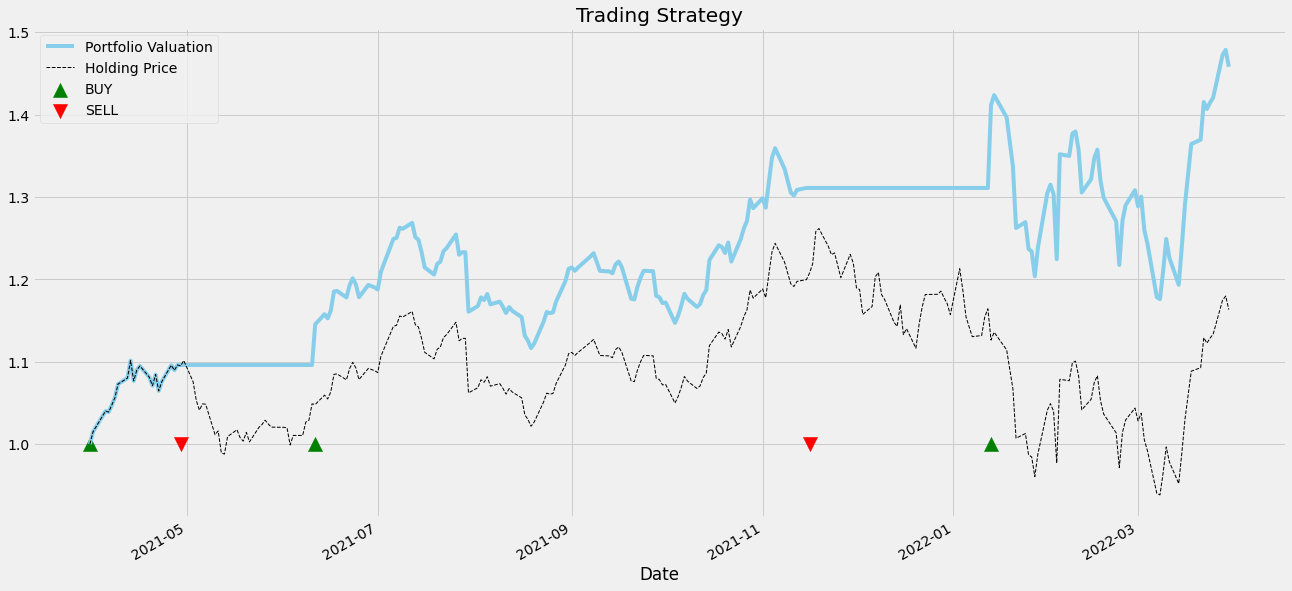

In [207]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)
df2_close['Value'].plot(label = 'Portfolio Valuation', color = 'skyblue')
df2_close['RebasedPrice'].plot(label = 'Holding Price', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df2_close.index, buy_signal, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df2_close.index, sell_signal, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.legend(loc = 'upper left')
plt.title('Trading Strategy')
plt.show()

# Portfolio Optimisation

Modern Portfolio Theory, or also known as mean-variance analysis is a mathematical process which allows the user to maximize returns for a given risk level. Every asset in a portfolio has its own rate expected returns and risks. It is possible to create multiple combinations of assets that can provide high returns for a pre-defined risk level.

Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘volatility’ on the X-axis. It shows the set of optimal portfolios that offer the highest expected return for a given risk level or the lowest risk for a given level of expected return.

In [12]:
returns # Extract data from Yfinance, and apply log returns function
for col in returns.columns:
    # print(returns[col].var())
    # And to examine standard deviation in a year (i.e. volatility)
    print(np.sqrt(returns[col].var() * 250))

0.24026529263558052
0.2490037719898426
0.23437135668822606
0.5335591917549186


A positive covariance means that returns of the two assets move together while a negative covariance means they move inversely. Risk and volatility can be reduced in a portfolio by pairing assets that have a negative covariance.

In [13]:
old_col = returns.columns[-1]
for col in returns.columns:
    print(returns[col].cov(returns[old_col]))

0.0002317243629075618
0.0001959341290490979
0.0002259191966935653
0.0011387416444246484


In [14]:
cov_matrix = returns.cov()

In [15]:
cov_matrix

,AAPL,GOOG,MSFT,TSLA
AAPL,0.000231,0.000156,0.000161,0.000232
GOOG,0.000156,0.000248,0.000184,0.000196
MSFT,0.000161,0.000184,0.000220,0.000226
TSLA,0.000232,0.000196,0.000226,0.001139


In [18]:
corr_matrix = returns.corr()

In [19]:
corr_matrix

,AAPL,GOOG,MSFT,TSLA
AAPL,1.000000,0.651654,0.713498,0.451896
GOOG,0.651654,1.000000,0.787944,0.368690
MSFT,0.713498,0.787944,1.000000,0.451654
TSLA,0.451896,0.368690,0.451654,1.000000


Define weights for portfolio, problem of portfolio optimisation is to determine the weights

In [20]:
w = {'AAPL': 0.1, 'GOOG': 0.2, 'MSFT': 0.5, 'TSLA': 0.2}
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

0.0002419328531559094

In [54]:
returns = df2_close.resample('Y').last().pct_change().mean()

In [56]:
vol = df2_close.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))

In [57]:
assets = pd.concat([returns, vol], axis=1)

In [58]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights
num_assets = len(df2_close.columns)
num_portfolios = 10000

In [59]:
# We simulate different weightings to generate portfolio returns and volatility
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    ret = np.dot(weights, returns) # Returns are the product of individual expected returns of asset and weight

    p_ret.append(ret)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    stan_dev = np.sqrt(var) # Daily standard deviation
    volatility = stan_dev*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(volatility)

In [60]:
data = {'Returns':p_ret, 'Volatility':p_vol}

In [61]:
for counter, symbol in enumerate(df2_close.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [62]:
portfolios = pd.DataFrame(data)

In [63]:
portfolios

,Returns,Volatility,AAPL weight,GOOG weight,MSFT weight,TSLA weight
0,-0.015744,0.241038,0.227127,0.293040,0.290447,0.189386
1,-0.018135,0.228972,0.320405,0.249618,0.305142,0.124836
2,-0.008701,0.244374,0.263650,0.353328,0.178397,0.204625
3,-0.004427,0.269720,0.335107,0.146012,0.214350,0.304530
4,-0.013063,0.231032,0.340188,0.299977,0.223169,0.136667
...,...,...,...,...,...,...
9995,-0.017123,0.251283,0.279055,0.112368,0.376172,0.232404
9996,0.002999,0.269843,0.307647,0.325450,0.060773,0.306130
9997,0.008768,0.290792,0.284721,0.330671,0.008066,0.376542
9998,0.000743,0.296176,0.040499,0.471813,0.098832,0.388856


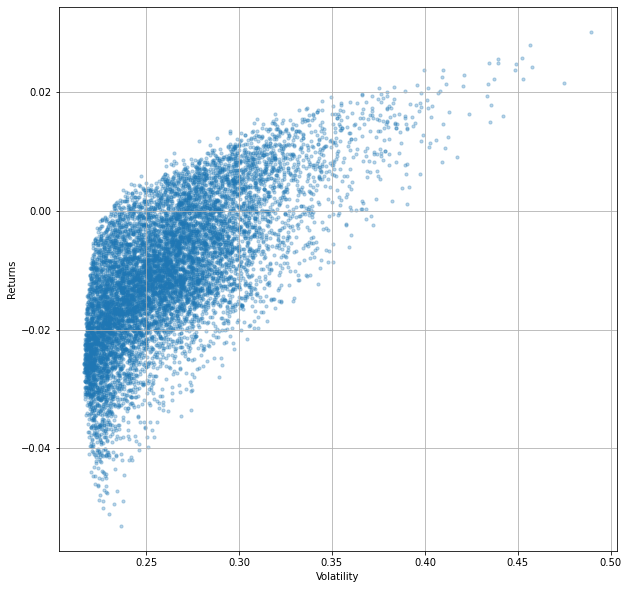

In [64]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [65]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]

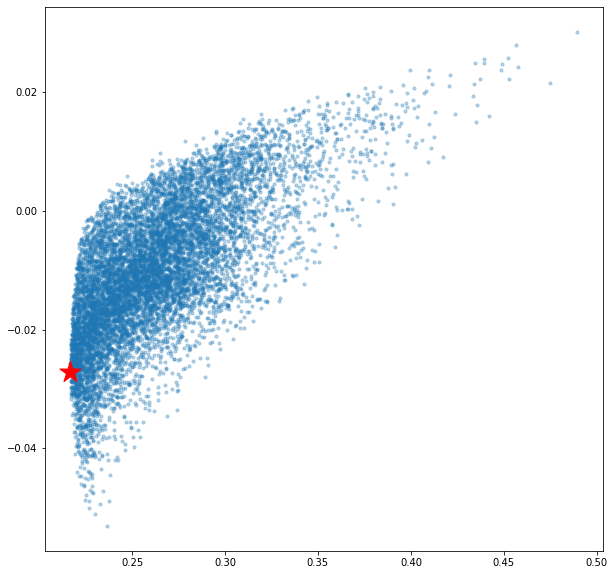

In [67]:
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

The Sharpe Ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. The optimal risky portfolio is the one with the highest Sharpe ratio.

In [68]:
risk_free_rate = 0.01
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-risk_free_rate)/portfolios['Volatility']).idxmax()]

In [69]:
optimal_risky_port

Returns        0.030088
Volatility     0.489531
AAPL weight    0.016372
GOOG weight    0.077628
MSFT weight    0.007598
TSLA weight    0.898402
Name: 8637, dtype: float64

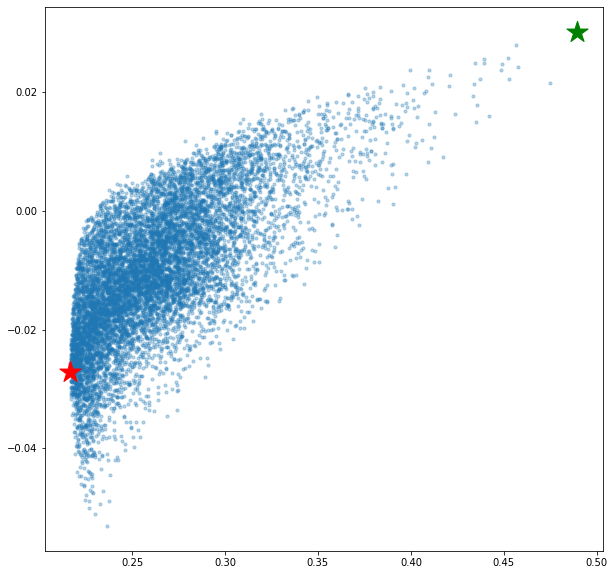

In [70]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

# Strategy One: Bollinger Bands

Bollinger Bands are great to observe the volatility of a given investment over a period of time. It is based on the simple moving average (SMA) of the investment adding the standard deviation of the SMA.

Basic trading strategy using the Bollinger Bands indicator which will shoot a buy signal if the stock price of the previous day is greater than the previous day's lower band and the current stock price is lesser than the current day’s lower band. 

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 
import requests
import math
from termcolor import colored as cl 
import numpy as np

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [ ]:
!pip install yfinance

In [ ]:
from yfinance import Ticker
def get_ohlc(ticker, period='60d', interval='5m'):
  cols = ['Open','High','Low','Close']
  ohlc = Ticker(ticker).history(period=period, interval=interval)[cols][:-1]
  return ohlc

In [ ]:
df1 = get_ohlc('ETH-USD')

In [ ]:
def SMovingAve(data, window):
    sma = data.rolling(window = window).mean()
    return sma

In [ ]:
df1['SMA_20'] = SMovingAve(df1['Close'], 3*12*24)

In [ ]:
def BollingerBand(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

In [ ]:
df1['HigherBB'], df1['LowerBB'] = BollingerBand(df1['Close'], df1['SMA_20'], 3*12*24)

In [ ]:
df1.tail(10)

,Open,High,Low,Close,SMA_20,HigherBB,LowerBB
Datetime,,,,,,,
2022-04-03 17:20:00+00:00,3491.813232,3491.813232,3489.792969,3489.997314,3416.592292,3594.868489,3238.316095
2022-04-03 17:25:00+00:00,3488.405762,3488.405762,3487.097900,3487.097900,3416.829461,3594.934722,3238.724201
2022-04-03 17:30:00+00:00,3486.160645,3486.160645,3484.440674,3486.042969,3417.053101,3595.019971,3239.086231
2022-04-03 17:35:00+00:00,3485.872070,3487.883545,3485.872070,3487.574219,3417.278709,3595.108181,3239.449236
2022-04-03 17:40:00+00:00,3487.341064,3489.909180,3487.341064,3489.842041,3417.503826,3595.207531,3239.800121
2022-04-03 17:45:00+00:00,3490.189453,3490.606934,3489.426514,3489.426514,3417.731546,3595.298867,3240.164225
2022-04-03 17:50:00+00:00,3489.350586,3489.350586,3488.393066,3488.942627,3417.951476,3595.400168,3240.502784
2022-04-03 17:55:00+00:00,3489.739990,3491.666748,3489.739990,3491.286621,3418.175955,3595.504279,3240.847631
2022-04-03 18:00:00+00:00,3491.157959,3493.252686,3491.157959,3493.252686,3418.411527,3595.597175,3241.225879


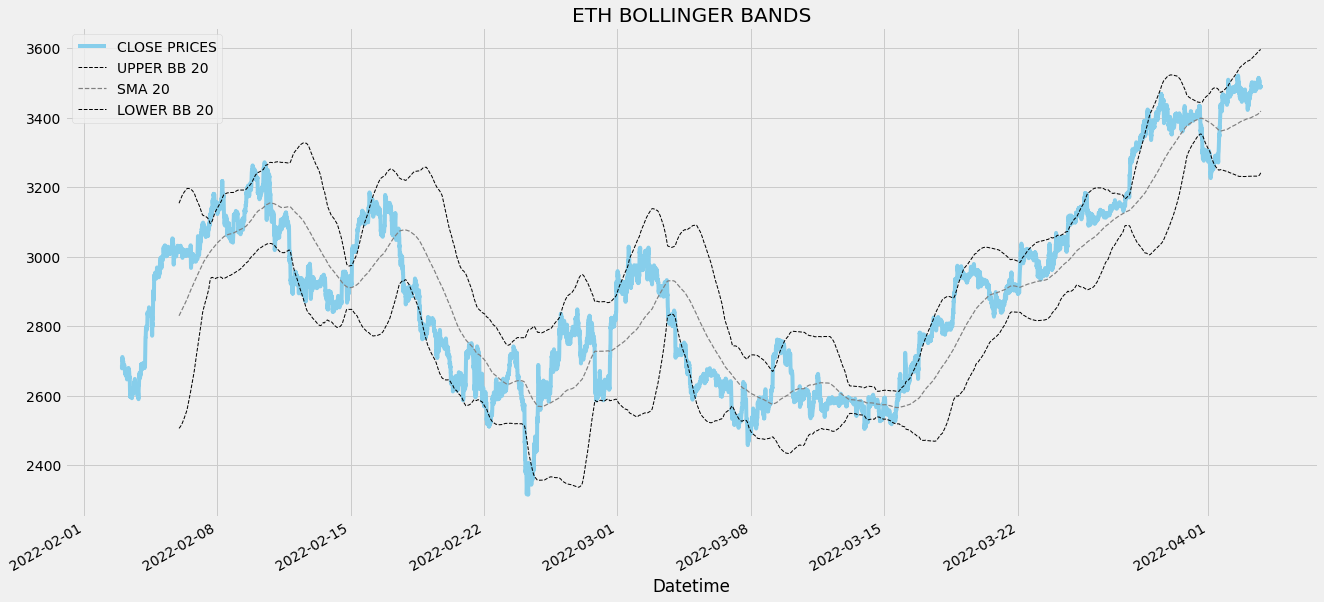

In [ ]:
df1['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
df1['HigherBB'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
df1['SMA_20'].plot(label = 'SMA 20', linestyle = '--', linewidth = 1.2, color = 'grey')
df1['LowerBB'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('ETH BOLLINGER BANDS')
plt.show()

In [ ]:
def BollingBandStrategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [ ]:
buy_price, sell_price, bb_signal = BollingBandStrategy(df1['Close'], df1['LowerBB'], df1['HigherBB'])

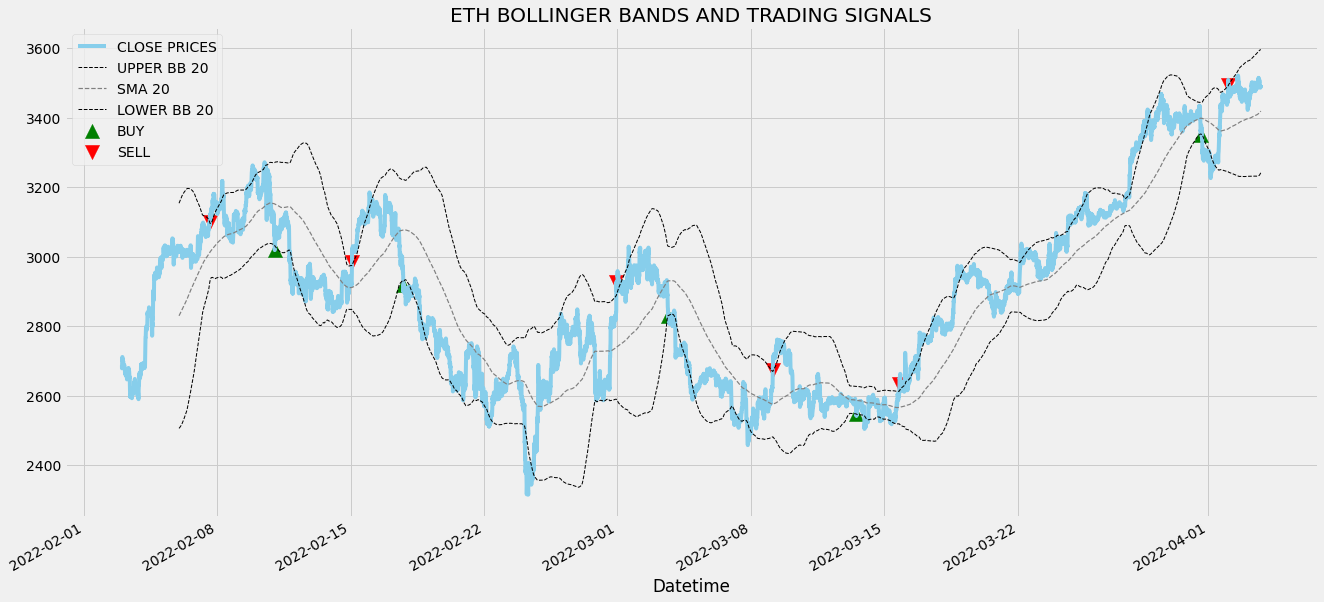

In [ ]:
df1['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
df1['HigherBB'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
df1['SMA_20'].plot(label = 'SMA 20', linestyle = '--', linewidth = 1.2, color = 'grey')
df1['LowerBB'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df1.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df1.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.legend(loc = 'upper left')
plt.title('ETH BOLLINGER BANDS AND TRADING SIGNALS')
plt.show()

In [ ]:
df1['pct_change1'] = df1['Close'].pct_change()

In [ ]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df1['Close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [ ]:
ret = pd.DataFrame(np.diff(df1['close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(tsla_ret)):
    try:
        returns = tsla_ret['returns'][i]*strategy['bb_position'][i]
        bb_strategy_ret.append(returns)
    except:
        pass
    
bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df1['close'][-1])
bb_investment_ret = []

for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the BB strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the BB strategy : {}%'.format(profit_percentage), attrs = ['bold']))

# Relative Strength Index

Exponential Moving Average (EMA) of the gain and loss of an asset. The Relative Strength of an asset is determined by dividing the Exponential Moving Average of the gain of an asset from the Exponential Moving Average of the loss of an asset for a specified number of periods.

In [71]:
def RSI(data, lookback):
    ret = data.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(data.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

In [ ]:
df2_close['GOOG_RSI_14'] = RSI(df2_close['GOOG'], 14)

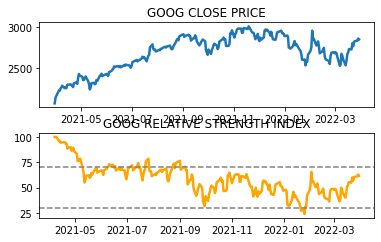

In [83]:
plt.subplots(figsize=[10,10])
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(df2_close['GOOG'], linewidth = 2.5)
ax1.set_title('GOOG CLOSE PRICE')
ax2.plot(df2_close['GOOG_RSI_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('GOOG RELATIVE STRENGTH INDEX')
plt.show()